## Курс Open Data Science

### Соревнование "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"

#### Практически весь код (90% и больше) взят из 1 части домашнего задания 4. [solution]_hw4_part1_websites_logistic_regression

#### Вольный слушатель IlgizA

In [2]:
# загрузим библиотеки и установим опции

from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix
from scipy.sparse import hstack

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve

In [3]:
# загрузим обучающую и тестовую выборки
train_df = pd.read_csv('./train_sessions.csv', index_col='session_id')
test_df  = pd.read_csv('./test_sessions.csv',  index_col='session_id')

In [4]:
# приведем колонки time1, ..., time10 к временному формату
times = [i for i in train_df.columns if i.startswith('time')]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

In [5]:
# приведем колонки site1, ..., site10 к целочисленному формату и заменим пропуски нулями
sites = [i for i in train_df.columns if i.startswith('site')]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [6]:
# отсортируем данные по времени
train_df = train_df.sort_values(by='time1')

In [7]:
train_df.shape

(253561, 21)

In [8]:
train_df[train_df.target==1].time1.apply(lambda x: ((x.year*100 + x.month)*100 + x.day)*100 + x.hour).value_counts().sort_index().head(20)

2013021216     56
2013021217      5
2013041209     38
2013091215      1
2013091216    276
2013091217     87
2013091218     13
2013111512     22
2013111513     40
2013111514      3
2013111816     19
2013111817     18
2013111915      1
2013111916     13
2013111917     59
2013111918     28
2013112212     41
2013112213     59
2013112911      1
2013112912    113
Name: time1, dtype: int64

Итог: Удалил данные трейна до ноября 2013. Посчитал их лишними (возможно зря). 
Причины: 
В эти дни Элис была всего три раза 2013-02-12, 2013-04-12, 2013-09-12 (и только 12 числа!)
2013-04-12 - Единственный день, когда Элис вышла в сеть в 9 утра. В остальные дни Элис выходила только после 11.
Возможно это была не Элис?

In [27]:
# Удалил данные трейна до ноября 2013.
train_df.drop(train_df[train_df.time1<'2013-11-01 00:00:00'].index, inplace=True)

In [10]:
# создадим отдельный датафрейм, где будем работать со временем
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# найдем время начала и окончания сессии
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

In [11]:
# введем дополнительные аналитики
time_df['Y']= time_df['min'].apply(lambda x: x.year)
time_df['M']= time_df['min'].apply(lambda x: x.month)
time_df['D']= time_df['min'].apply(lambda x: x.day)
time_df['H']= time_df['min'].apply(lambda x: x.hour)
time_df['W']= time_df['min'].apply(lambda x: x.date().weekday()) # день недели: 0-понедельник, ... , 6-воскресение

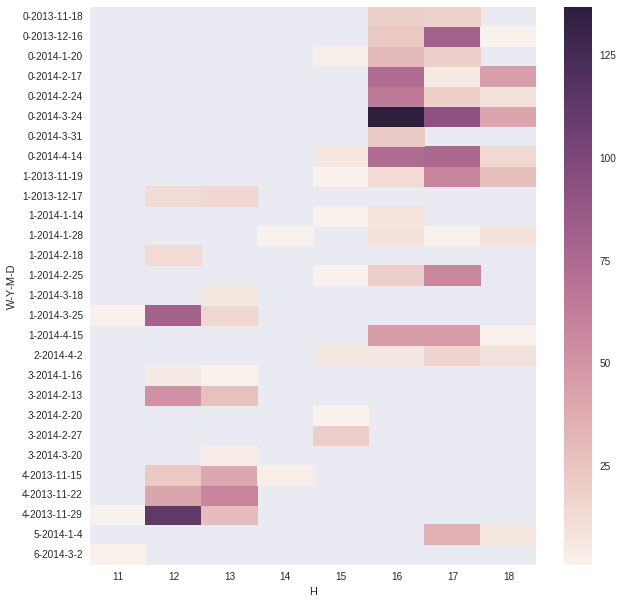

In [12]:
# Хитмап - анализируем распределение по часам
plt.figure(figsize=(10,10))
sns.heatmap(time_df[time_df.target==1].pivot_table(values='target', index=['W','Y','M','D'], columns=['H'], aggfunc=np.sum ));

Из этой диаграммы видно, что Элис выходит в сеть либо только до ланча, либо только после.
Ни разу не была в сети весь день: по понедельникам Элис выходит только во второй половине дня, по пятницам только в первой половине дня. Причем по пятницам только в 2013 году

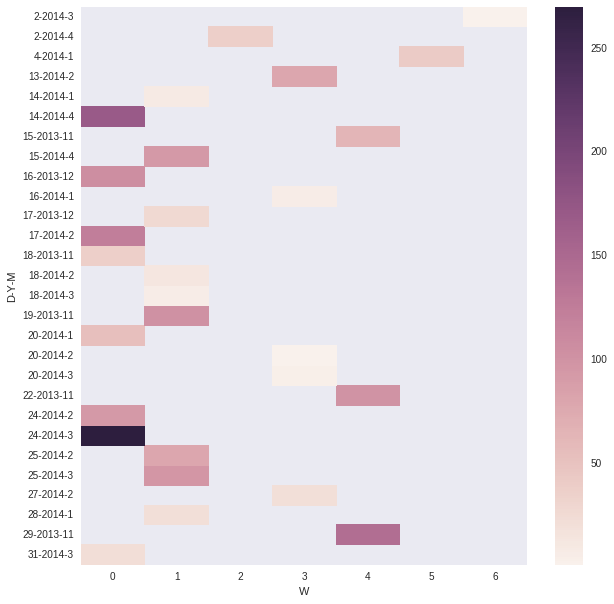

In [13]:
# Хитмап - анализируем распределение по дням недели

plt.figure(figsize=(10,10))
sns.heatmap(time_df[time_df.target==1].pivot_table(values='target', index=['D','Y','M'], columns='W', aggfunc=np.sum ));

Из этой диаграммы можно сделать такие выводы - В первых днях месяца Элис за все время выходила только по одному дню в воскресение, субботу, среду. Во второй половине месяца Элис выходит только по понедельникам, вторникам, четвергам и пятницам.

In [29]:
# определяем "режим работы"
time_df[time_df['target']==1].groupby(by=['Y','M','D']).agg({'max':max,'min':min,'H':min,'target':'count'})[['H','min','max','target']].sort_values(by='H')


,,,H,min,max,target
Y,M,D,,,,
2014,3,2,11,2014-03-02 11:55:52,2014-03-02 11:55:52,1
2013,11,29,11,2013-11-29 11:59:01,2013-11-29 13:21:50,143
2014,3,25,11,2014-03-25 11:53:25,2014-03-25 13:21:10,97
2013,11,15,12,2013-11-15 12:18:58,2013-11-15 14:04:16,65
2014,2,18,12,2014-02-18 12:06:00,2014-02-18 12:13:48,13
2013,11,22,12,2013-11-22 12:13:22,2013-11-22 13:33:27,100
2014,2,13,12,2014-02-13 12:29:33,2014-02-13 13:51:47,79
2013,12,17,12,2013-12-17 12:27:53,2013-12-17 13:43:14,28
2014,1,16,12,2014-01-16 12:35:03,2014-01-16 13:04:20,6


 Данных по дням Элис мало. Все дни уместились в одну небольшую табличку.
 При этом складывается определенный распорядок дня "работы". Визуально примерно такой: 
 либо с 11:50 до 14:10  (верхняя часть таблицы);
 либо с 15:50 до 18:15  (нижняя часть таблицы)

In [15]:
# наша целевая переменная
y_train = train_df['target']

# объединенная таблица исходных данных
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# индекс, по которому будем отделять обучающую выборку от тестовой
idx_split = train_df.shape[0]

In [16]:
# табличка с индексами посещенных сайтов в сессии
full_sites = full_df[sites]

In [17]:
# последовательность с индексами
sites_flatten = full_sites.values.flatten()

# искомая матрица
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [18]:
print( "full_sites_sparse.shape" , full_sites_sparse.shape)

full_sites_sparse.shape (312728, 48371)


In [19]:
# датафрейм для новых признаков
full_new_feat = pd.DataFrame(index=full_df.index)

full_new_feat['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour) 
full_new_feat['dec_1w'] = full_df['time1'].apply(lambda ts: int(ts.day<=7)) # первые семь дней месяца  (на глазок)
full_new_feat['dec_1'] = full_df['time1'].apply(lambda ts: int(ts.day> 10)) # вторая и третья декада   (тоже грубое приближение)
full_new_feat['before'] = full_df['time1'].apply(lambda ts: int((ts.hour*60+ts.minute >=11*60+50) 
                                                              & (ts.hour*60+ts.minute <=14*60+10))) # первая половина дня
full_new_feat['after'] = full_df['time1'].apply(lambda ts: int((ts.hour*60+ts.minute >=15*60) 
                                                              & (ts.hour*60+ts.minute <=18*60+15))) # вторая половина дня

In [20]:
# каждый день недели как признак
for i in range(0,7):
    week_d = 'wd_'+str(i)
    full_new_feat[week_d] = full_df['time1'].apply(lambda ts: int(ts.date().weekday()==i))

In [21]:
# то же самое с часами с учетом того, что 7 часов это самое раннее время всех сессий
full_new_feat['h_7'] = full_new_feat['start_hour'].apply(lambda hour: int(hour <= 7))
for i in range(8,24):
    h_i = 'h_'+str(i)
    full_new_feat[h_i] = full_new_feat['start_hour'].apply(lambda hour: int(hour == i))

In [22]:
# столбцы фичи для обучения
wd = [i for i in full_new_feat.columns if i.startswith('wd_')]
hs = [i for i in full_new_feat.columns if i.startswith('h_')]
print(wd)
print(hs)

['wd_0', 'wd_1', 'wd_2', 'wd_3', 'wd_4', 'wd_5', 'wd_6']
['h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20', 'h_21', 'h_22', 'h_23']


In [23]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

def plot_valid(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)

# функция для записи прогнозов в файл
def write_to_submission_file(predicted_labels, out_file, target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels, index = np.arange(1, predicted_labels.shape[0] + 1), columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)    

[ 0.06309573  0.09027252  0.12915497  0.18478498  0.26437612  0.37824899
  0.54116953  0.77426368  1.10775685  1.58489319]
CPU times: user 3min 16s, sys: 171 ms, total: 3min 16s
Wall time: 3min 16s


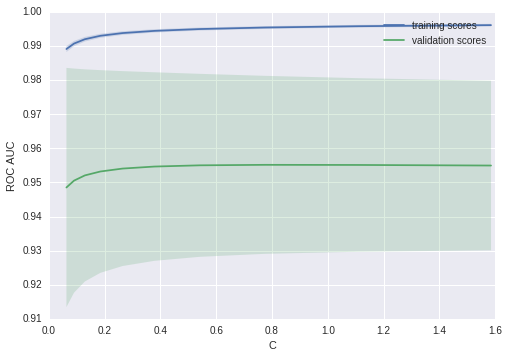

In [30]:
%%time
# проводим валидацию модели и определяем лучший параметр С 
tmp_new = full_new_feat[wd + hs + ['before','after','dec_1','dec_1w']].as_matrix()
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp_new[:idx_split,:]]))

c_values = np.logspace(-1.2, 0.2, 10)
print(c_values) 
logit_searcher = LogisticRegression(n_jobs=-1, random_state=17)

val_train, val_test = validation_curve(logit_searcher, X_train, y_train,
                                       param_name='C', param_range=c_values, cv=5,
                                       scoring='roc_auc')


plot_with_err(c_values, val_train, label='training scores')
plot_with_err(c_values, val_test, label='validation scores')
plt.xlabel('C'); plt.ylabel('ROC AUC')
plt.legend();

C= 0.8


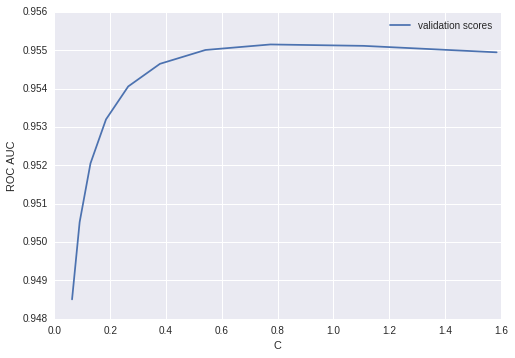

In [31]:
# эта же кривая валидации отдельно, чтобы определить параметр С

plot_valid(c_values, val_test, label='validation scores')  
plt.xlabel('C'); plt.ylabel('ROC AUC')
plt.legend();

print('C=', 0.8) 

Параметр регуляризации определил на глазок. Пусть будет 0.8

In [26]:
# Итоговое обучение
tmp_new = full_new_feat[wd + hs + ['before','after','dec_1','dec_1w']].as_matrix()             

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp_new[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:],  tmp_new[idx_split:,:]]))

# C - на глаз из картинки
C=0.8

# обучим модель на всей выборке с оптимальным коэффициентом регуляризации
lr = LogisticRegression(C=C, random_state=17).fit(X_train, y_train)  

# сделаем прогноз для тестовой выборки
y_test = lr.predict_proba(X_test)[:, 1]

# запишем его в файл, готовый для сабмита
write_to_submission_file(y_test, './baseline.csv')



Этот сабмит дал на паблике результат - 0.95956, а в привате - 0.96070. Вот такое решение "на глазок". Большой выигрыш дало использование семи фич "день недели" вместо одной фичи "неделя". Увидев на этом прирос, так же побил часы на отдельные фичи.